# Learning to Extract Pain Outcomes from Clinical Text without Labeled Data
## II: Generative Model



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numba
import numpy as np
import matplotlib
import pandas as pd

from snorkel import SnorkelSession
from snorkel.learning.disc_models.rnn import *
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels
from snorkel.models import candidate_subclass, Document, Sentence, Candidate, Span
from snorkel.learning import GenerativeModel

In [3]:
session = SnorkelSession()

try:
    PainLocation = candidate_subclass('PainLocation', ['pain', 'anatomy'])
except:
    pass

### Load Candidates and Gold Labels

In [32]:
train_cands = session.query(Candidate).filter(Candidate.split == 0).order_by(Candidate.id).all()
dev_cands   = session.query(Candidate).filter(Candidate.split == 1).order_by(Candidate.id).all()
test_cands  = session.query(Candidate).filter(Candidate.split == 2).order_by(Candidate.id).all()

L_gold_train = load_gold_labels(session, split=0, annotator_name='gold')
L_gold_dev   = load_gold_labels(session, split=1, annotator_name='gold')
L_gold_test  = load_gold_labels(session, split=2, annotator_name='gold')

print "Candidates [TRAIN]", len(train_cands)
print "Candidates [DEV]  ", len(dev_cands)
print "Candidates [TEST] ", len(test_cands)

print "Gold [TRAIN]", L_gold_train.shape[0]
print "Gold [DEV]  ", L_gold_dev.shape[0]
print "Gold [TEST] ", L_gold_test.shape[0]

# Depending on your choice of parser, some candidates might be identified that were not originally labeled
# in our gold test set. This hack just sets those unknown labels to negative
L_gold_train[L_gold_train == 0] = -1
L_gold_dev[L_gold_dev == 0]     = -1
L_gold_test[L_gold_test == 0]   = -1

Candidates [TRAIN] 225
Candidates [DEV]   63
Candidates [TEST]  168
Gold [TRAIN] 225
Gold [DEV]   63
Gold [TEST]  168


In [5]:
documents = session.query(Document).all()
candidates = train_cands + dev_cands + test_cands

## Weak Supervision
Load our labeling function (LF) implementations

In [10]:
from rwe.labelers import *

# get our pain/anatomy relation labeling functions
lfs = get_labeling_functions("pain_anatomy")

print "Loaded {} labeling functions\n".format(len(lfs))
for lf in lfs:
    print lf.__name__

Loaded 25 labeling functions

LF_candidate_in_checklist
LF_candidate_in_list
LF_complains_of
LF_contiguous_left_pain
LF_contiguous_right_pain
LF_date_between
LF_far_apart
LF_history_of_present_illness
LF_left_pain_anatomy_between
LF_left_pain_multiple_anat
LF_less_far_apart
LF_long_distance_left_pain
LF_misattached_entities
LF_misattached_entities2
LF_misattached_entities3
LF_near_contiguous_left_pain
LF_near_contiguous_right_pain
LF_negated_term_between_entities
LF_negex_definite_negation_left
LF_negex_definite_negation_right
LF_pain_between_entities
LF_pain_score_location
LF_past_medical_history
LF_radiograph_view
LF_warning_signs_hypothetical


### Applying Labeling Functions

In [19]:
labeler = LabelAnnotator(lfs=lfs)

In [20]:
L_train = labeler.apply(split=0, parallelism=1)
L_dev   = labeler.apply_existing(split=1, parallelism=1)
L_test  = labeler.apply_existing(split=2, parallelism=1)

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%



### Labeling Function Empirical Accuracy Statistics
Since we have labeled training data, we can examine empirical statistics for labeling function performance. Good labeling function design requires than any heuristic be correct with probablity better than random chance. 

In [21]:
L_train.lf_stats(session, labels=L_gold_train.toarray().ravel())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_candidate_in_checklist,0,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_candidate_in_list,1,0.275556,0.275556,0.057778,0,0,5,57,0.919355
LF_complains_of,2,0.022222,0.022222,0.000000,4,1,0,0,0.800000
LF_contiguous_left_pain,3,0.004444,0.004444,0.004444,1,0,0,0,1.000000
LF_contiguous_right_pain,4,0.364444,0.111111,0.066667,53,29,0,0,0.646341
LF_date_between,5,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_far_apart,6,0.115556,0.115556,0.000000,0,0,0,25,1.000000
LF_history_of_present_illness,7,0.044444,0.040000,0.004444,8,2,0,0,0.800000
LF_left_pain_anatomy_between,8,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_left_pain_multiple_anat,9,0.000000,0.000000,0.000000,0,0,0,0,NaN


## Training the Generative Model
Grid search for tuning.

In [22]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# use grid search to optimize the generative model
step_size_param     = ListParameter('step_size', [0.01 / L_train.shape[0]])
decay_param         = ListParameter('decay', [0.9])
epochs_param        = ListParameter('epochs', [200, 500])
reg_param           = ListParameter('reg_param', [0.001, 0.01])
reg_type            = ListParameter('reg_type', [1])
prior_param         = ListParameter('LF_acc_prior_weight_default', [1.0, 0.9, 0.8])

# search for the best model
param_grid = [step_size_param, decay_param, epochs_param, reg_param, reg_type, prior_param]
searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=5, lf_propensity=True)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=set())

run_stats

Initialized RandomSearch search of size 5. Search space size = 12.
[1] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 500, reg_param = 1.00e-02, reg_type = 1, LF_acc_prior_weight_default = 8.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.775510204082
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 500, reg_param = 1.00e-03, reg_type = 1, LF_acc_prior_weight_default = 8.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.714285714286
[3] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 500, reg_param = 1.00e-02, reg_type = 1, LF_acc_prior_weight_default = 8.00e-01
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.714285714286
[4] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 200, reg_param = 1.00e-03, reg_type = 1, LF_acc_prior_weight_default = 1.00e+00
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.775510204082
[5] Testing step_size = 4.44e-05, decay = 9.00e

,step_size,decay,epochs,reg_param,reg_type,LF_acc_prior_weight_default,Prec.,Rec.,F1
0,0.000044,0.9,500,0.010,1,0.8,0.760,0.791667,0.775510
3,0.000044,0.9,200,0.001,1,1.0,0.760,0.791667,0.775510
1,0.000044,0.9,500,0.001,1,0.8,0.625,0.833333,0.714286
2,0.000044,0.9,500,0.010,1,0.8,0.625,0.833333,0.714286
4,0.000044,0.9,200,0.010,1,1.0,0.625,0.833333,0.714286


In [42]:
from snorkel.annotations import load_marginals, save_marginals

train_marginals = gen_model.marginals(L_train)
save_marginals(session, L_train, train_marginals, training=True)

Saved 225 marginals


###  Labeling Function Accuracy Weights
These are the accuracy factor weights learned during training

In [27]:
lf_accs = []
for name,acc in zip([lf.__name__ for lf in lfs], gen_model.weights.lf_accuracy):
    lf_accs.append({"LF-NAME":name, "Acc. Factor Weight":acc})
pd.DataFrame(lf_accs)

,Acc. Factor Weight,LF-NAME
0,0.705487,LF_candidate_in_checklist
1,0.748036,LF_candidate_in_list
2,0.711785,LF_complains_of
3,0.709779,LF_contiguous_left_pain
4,0.744700,LF_contiguous_right_pain
5,0.711735,LF_date_between
6,0.730322,LF_far_apart
7,0.716052,LF_history_of_present_illness
8,0.710122,LF_left_pain_anatomy_between
9,0.707278,LF_left_pain_multiple_anat


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118101bd0>],
      dtype=object)

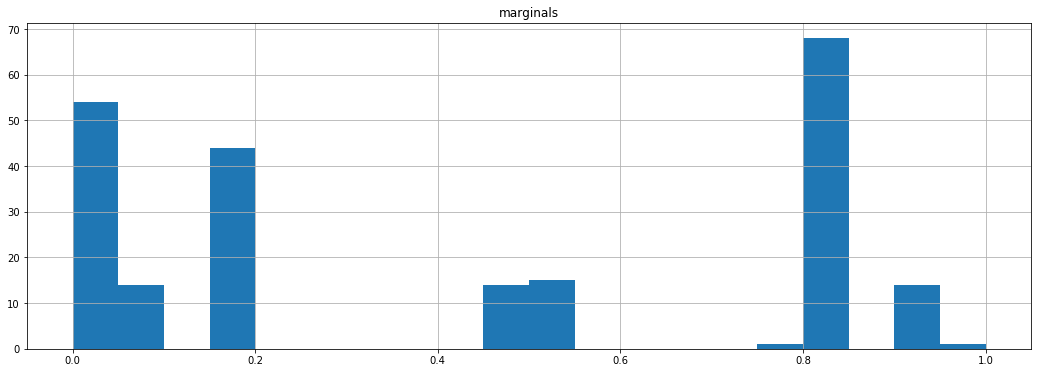

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 6))
df = pd.DataFrame(data=train_marginals, columns=['marginals'])
pd.DataFrame.hist(df,range=(0.0, 1.0),bins=20, ax=ax)

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def majority_vote(labels, gold_labels, title="Majority Vote"):
    
    mv = np.sum(labels,axis=1)
    mv[mv > 0] = 1
    mv[mv <= 0] = -1
    
    y_pred = np.ravel(mv)
    y_true = gold_labels.toarray()
    
    print "=" * 40
    print title
    print "=" * 40
    pos, neg = list(gold_labels).count(1),float(list(gold_labels).count(-1))
    print "pos/neg   {:.2f} {:.2f}".format(pos/(pos+neg), neg/(pos+neg))
    print "precision {:.2f}".format( 100 * precision_score(y_true, y_pred) )
    print "recall    {:.2f}".format( 100 * recall_score(y_true, y_pred) )
    print "f1        {:.2f}".format( 100 * f1_score(y_true, y_pred) )
    print "-" * 40

def score(marginals, gold_labels, title=""):
    y_pred = [1 if marginals[i] > 0.5 else -1 for i in range(0,len(marginals))]
    y_true = gold_labels.toarray()
    
    print "=" * 40
    print title
    print "=" * 40
    pos,neg = list(gold_labels).count(1),float(list(gold_labels).count(-1))
    print "pos/neg   {:.2f} {:.2f}".format(pos/(pos+neg), neg/(pos+neg))
    print "precision {:.2f}".format( 100 * precision_score(y_true, y_pred) )
    print "recall    {:.2f}".format( 100 * recall_score(y_true, y_pred) )
    print "f1        {:.2f}".format( 100 * f1_score(y_true, y_pred) )
    print "-" * 40

### Training Set: Majority Vote vs. Generative Model

We should see a slight boost on overall F1 performance when using the generative model. Generally, we train a small amount of precision for a big boost in recall. Even when using small amounts of data, such as just ShARe/CLEF notes, we see performance benefits:

**Majority Vote**
```
precision 69.05
recall    81.69
f1        74.84
```
**Generative Model**
```
precision 68.97
recall    84.51
f1        75.95
```

In [33]:
def mv_vs_gen(marginals, L_mat, gold):
    majority_vote(L_mat, gold)
    score(marginals, gold, "Generative Model")
    
mv_vs_gen(train_marginals, L_train, L_gold_train)

Majority Vote
pos/neg   0.32 0.68
precision 69.05
recall    81.69
f1        74.84
----------------------------------------
Generative Model
pos/neg   0.32 0.68
precision 68.97
recall    84.51
f1        75.95
----------------------------------------


### Dev Set: Majority Vote

In [34]:
majority_vote(L_dev, L_gold_dev)

Majority Vote
pos/neg   0.38 0.62
precision 76.00
recall    79.17
f1        77.55
----------------------------------------


### Test Set: Majority Vote

In [35]:
majority_vote(L_test, L_gold_test)

Majority Vote
pos/neg   0.27 0.73
precision 68.42
recall    84.78
f1        75.73
----------------------------------------
